## Critério de Vacinação para Covid-19 Utilizando Programação Linear
### Universidade Federal de Minas Gerais - Disciplina Pesquisa Operacional<br>
Professor: Eduardo Gontijo Carrano<br>
Aluno: Antonio Carlos da Anunciação<br>
Aluno: Hebert do Nascimento Amaral Costa<br>

---
Reumo:

Este trabalho visa desenvolver um modelo de programação linear com o objetivo de chegar na melhor estratégia de vacinação baseada na quantidade de doses disponiveis que minimize a quantidade de óbitos em BH pelo Covid-19.

---

In [1]:
import sys, os
import docplex.mp
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model

**Lendo os dados:**

    incidencia: taxa de incidencias das comorbidades por idade
    
    comorbidades: taxa de letalidade por comorbidade

In [2]:
data = np.genfromtxt('alphas.csv',delimiter=';')
populacao, incidencia = data[:,1], data[:,2:]
comorbidade = np.genfromtxt('betas.csv',delimiter=';')
max_vacina = 1000000
faixa_etaria = ['0-04','05-09','10-14','15-19','20-24',
                '25-29','30-34','35-39','40-44','45-49',
                '50-54','55-59','60-64','65-69','70-74',
                '75-79','80-84','85-89','90-95','95+']


<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

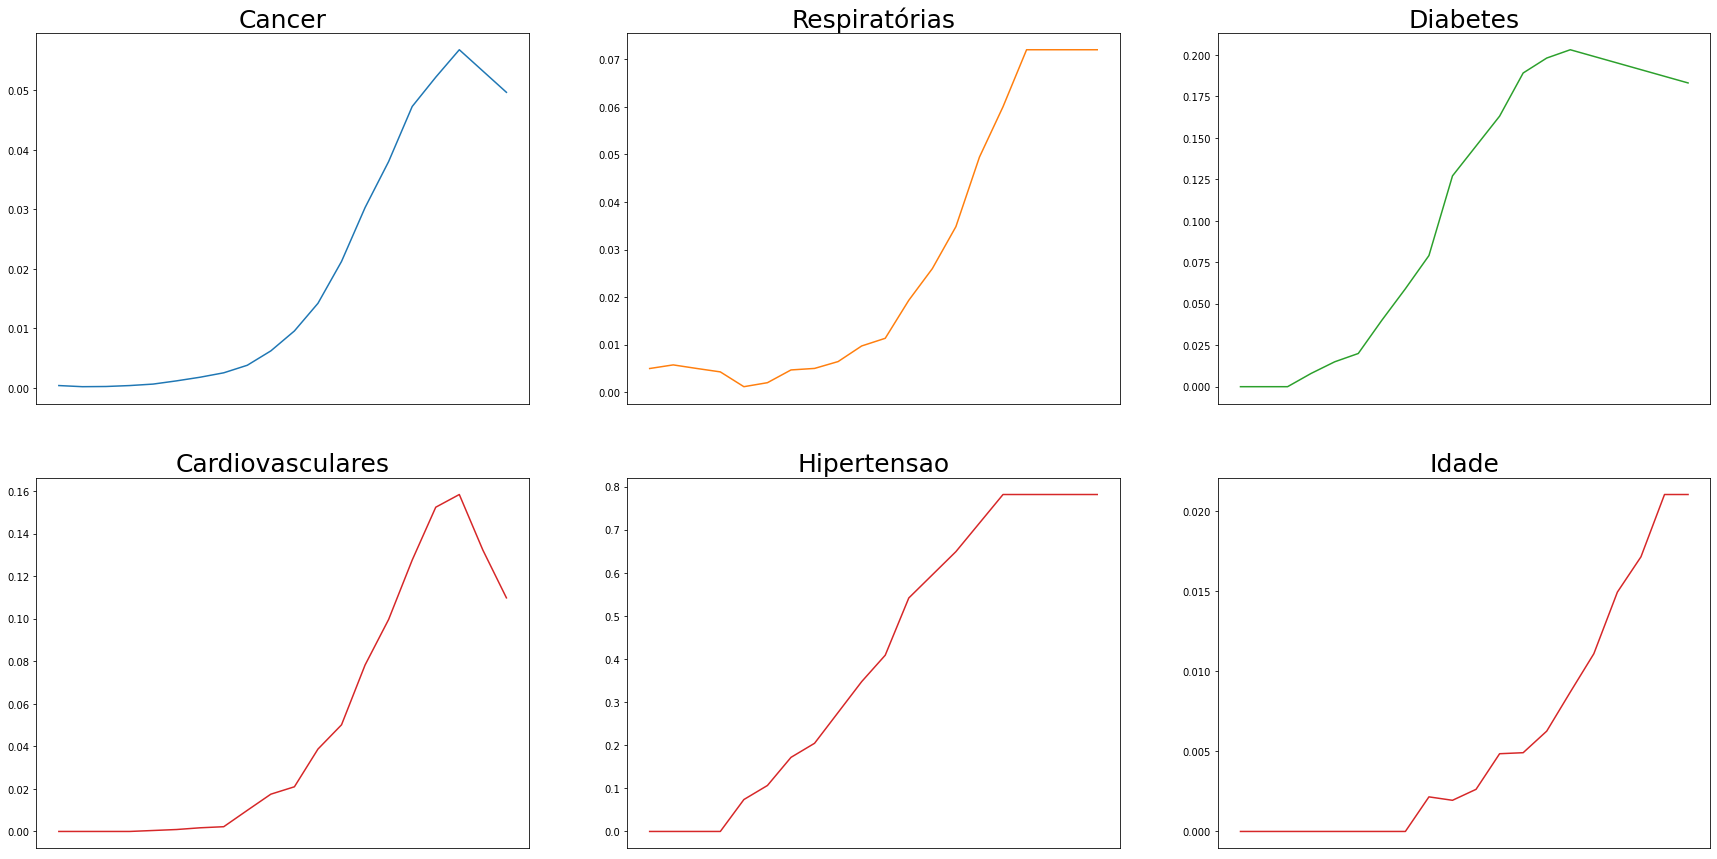

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
axs[0, 0].plot(faixa_etaria, incidencia[:,0])
axs[0, 0].set_title('Cancer', fontsize = 25)
axs[0, 0].get_xaxis().set_visible(False)
axs[0, 1].plot(faixa_etaria, incidencia[:,1], 'tab:orange')
axs[0, 1].set_title('Respiratórias', fontsize = 25)
axs[0, 1].get_xaxis().set_visible(False)
axs[0, 2].plot(faixa_etaria, incidencia[:,2], 'tab:green')
axs[0, 2].set_title('Diabetes', fontsize = 25)
axs[0, 2].get_xaxis().set_visible(False)
axs[1, 0].plot(faixa_etaria, incidencia[:,3], 'tab:red')
axs[1, 0].set_title('Cardiovasculares', fontsize = 25)
axs[1, 0].get_xaxis().set_visible(False)
axs[1, 1].plot(faixa_etaria, incidencia[:,4], 'tab:red')
axs[1, 1].set_title('Hipertensao', fontsize = 25)
axs[1, 1].get_xaxis().set_visible(False)
axs[1, 2].plot(faixa_etaria, incidencia[:,5], 'tab:red')
axs[1, 2].set_title('Idade', fontsize = 25)
axs[1, 2].get_xaxis().set_visible(False)
plt.xticks

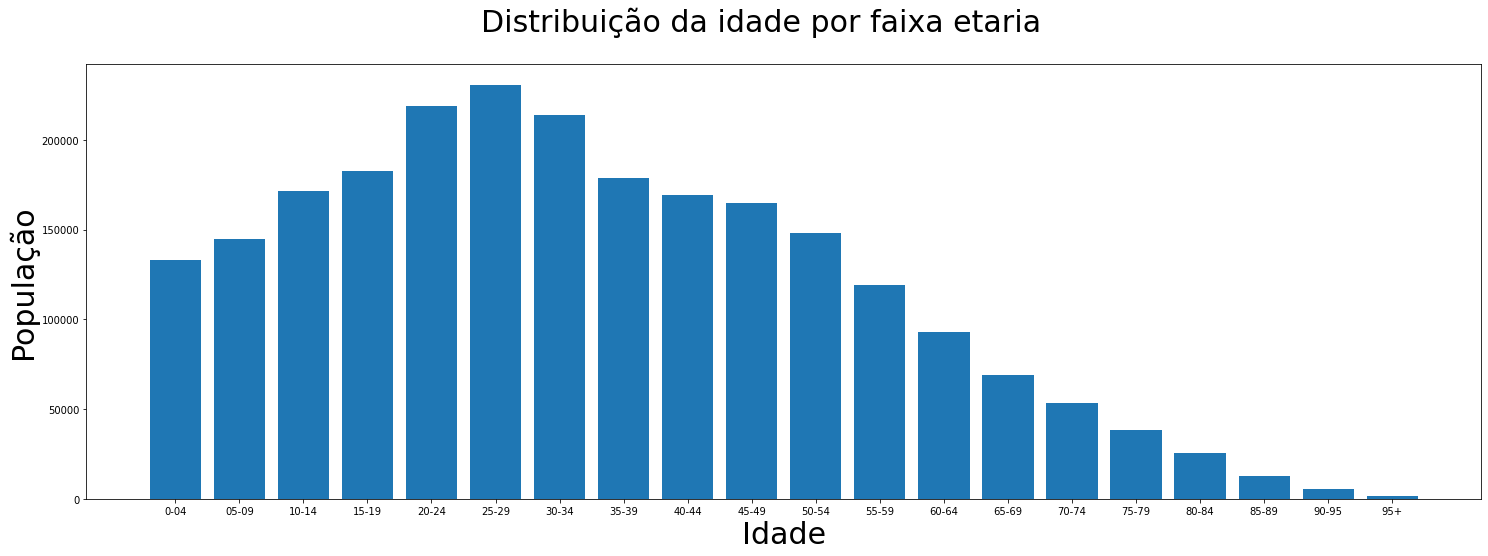

In [4]:
plt.figure(figsize=(25,8))
plt.bar(faixa_etaria, populacao)
plt.suptitle('Distribuição da idade por faixa etaria', fontsize=30)
plt.xlabel('Idade', fontsize=30)
plt.ylabel('População', fontsize=30)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.show()

In [5]:
populacao_total = sum(populacao)

#### Modelando o problema:


\begin{equation} min f(x_i) = \sum_{i}^{n} \gamma_i (Q_i - x_i)\end{equation}
\begin{equation}
Restrições:
    \begin{cases}
      \sum x_i \leq MaxVacinas\\
      \sum x_i \leq Populacao\\
      x_i \leq Q_i\\
      x_i \geq 0\\
    \end{cases}\,.
\end{equation}
\begin{equation} A = 
\begin{bmatrix}
\text{Cancer}\\
\text{Doenças respiratorias}\\
\text{Doenças cardiovasculares}\\
\text{Hipertensão}\\
\text{Ausencia de Comorbidades}\\
\end{bmatrix}
\end{equation}

O vetor acima representa a letalidade de doença de acordo com as comorbidades.

\begin{equation} \alpha_i= 
\begin{bmatrix}
\text{Incidencia Cancer}_i\\
\text{Incidencia Doenças respiratorias}_i\\
\text{Incidencia Doenças cardiovasculares}_i\\
\text{Incidencia Hipertensão}_i\\
\text{Incidencia Ausencia de Comorbidades}_i\\
\end{bmatrix}
\end{equation}

O vetor acima representa a taxa de incidencia das comorbidades que influencia na taxa de mortalidade da doença.

Então a equação:
\begin{equation} \gamma_i = A \alpha_i\end{equation}

Representa a taxa de letalidade total da doença de acordo com a faixa etária.


É interessante resaltar que o produto:
\begin{equation} \text{Ausencia de Comorbidades} \times \text{Incidencia Ausencia de Comorbidades}_i\end{equation}

   Representa simplesmente a taxa de mortalidade da doença para a idade 'i', em pessoas sem nenhuma comorbidades.

In [6]:
Gamma = np.dot(comorbidade, incidencia.transpose())

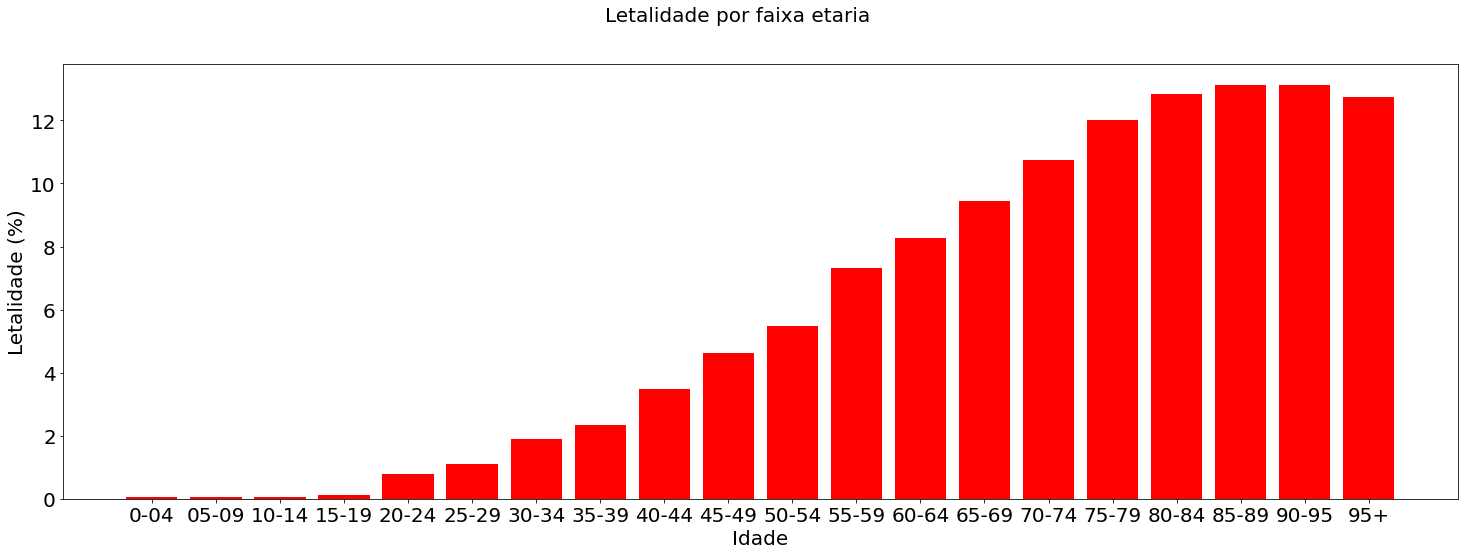

In [7]:
plt.figure(figsize=(25,8))
plt.bar(faixa_etaria, Gamma*100, color = 'red')
plt.suptitle('Letalidade por faixa etaria', fontsize=20)
plt.xlabel('Idade', fontsize=20)
plt.ylabel('Letalidade (%)', fontsize=20)
plt.rc('xtick', labelsize=2000) 
plt.rc('ytick', labelsize=20)
plt.show()

#### Modelando computacionalmente o problema usando o cplex:

In [8]:
modelo = Model(name='Projeto PO')

# Definindo a variaavel do tipo inteira:
x = modelo.integer_var_list(len(populacao))

In [9]:
# Definindo a função objetiva:
def objFunction(x):
    y = 0
    for i in range(0, len(populacao)):
        alpha = np.dot(incidencia[i,], comorbidade.transpose())
        y = y + alpha*(populacao[i]-x[i])
    return y

In [10]:
# Definindo as equações de restrições
modelo.add_constraint(sum(x) <= max_vacina)
for i in range(0, len(populacao)):
    modelo.add_constraint(x[i] >= 0)
    modelo.add_constraint(x[i] <= populacao[i])

In [11]:
# Modelo:
modelo.minimize(objFunction(x))

In [12]:
modelo.print_information()

Model: Projeto PO
 - number of variables: 20
   - binary=0, integer=20, continuous=0
 - number of constraints: 41
   - linear=41
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [13]:
X_solution = modelo.solve(log_output = True)
modelo.print_solution()

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Found incumbent of value 73666.539820 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 41 rows and 20 columns.
All rows and columns eliminated.
Presolve time = 0.02 sec. (0.02 ticks)

Root node processing (before b&c):
  Real time             =    0.02 sec. (0.02 ticks)
Parallel b&c, 4 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.02 sec. (0.02 ticks)
objective: 10577.028
  x8=99644
  x9=169321
  x10=164928
  x11=147948
  x12=118919
  x13=93188
  x14=69013
  x15=53404
  x16=38318
  x17=25400
  x18=12955
  x19=5357
  x20=1605


In [14]:
X_vacina = X_solution.get_all_values()

In [15]:
int(X_solution.get_objective_value())

10577

In [16]:
X_vacina_percentual = []
for i in range(0,len(X_vacina)):
    X_vacina_percentual.append(X_vacina[i]/populacao[i])

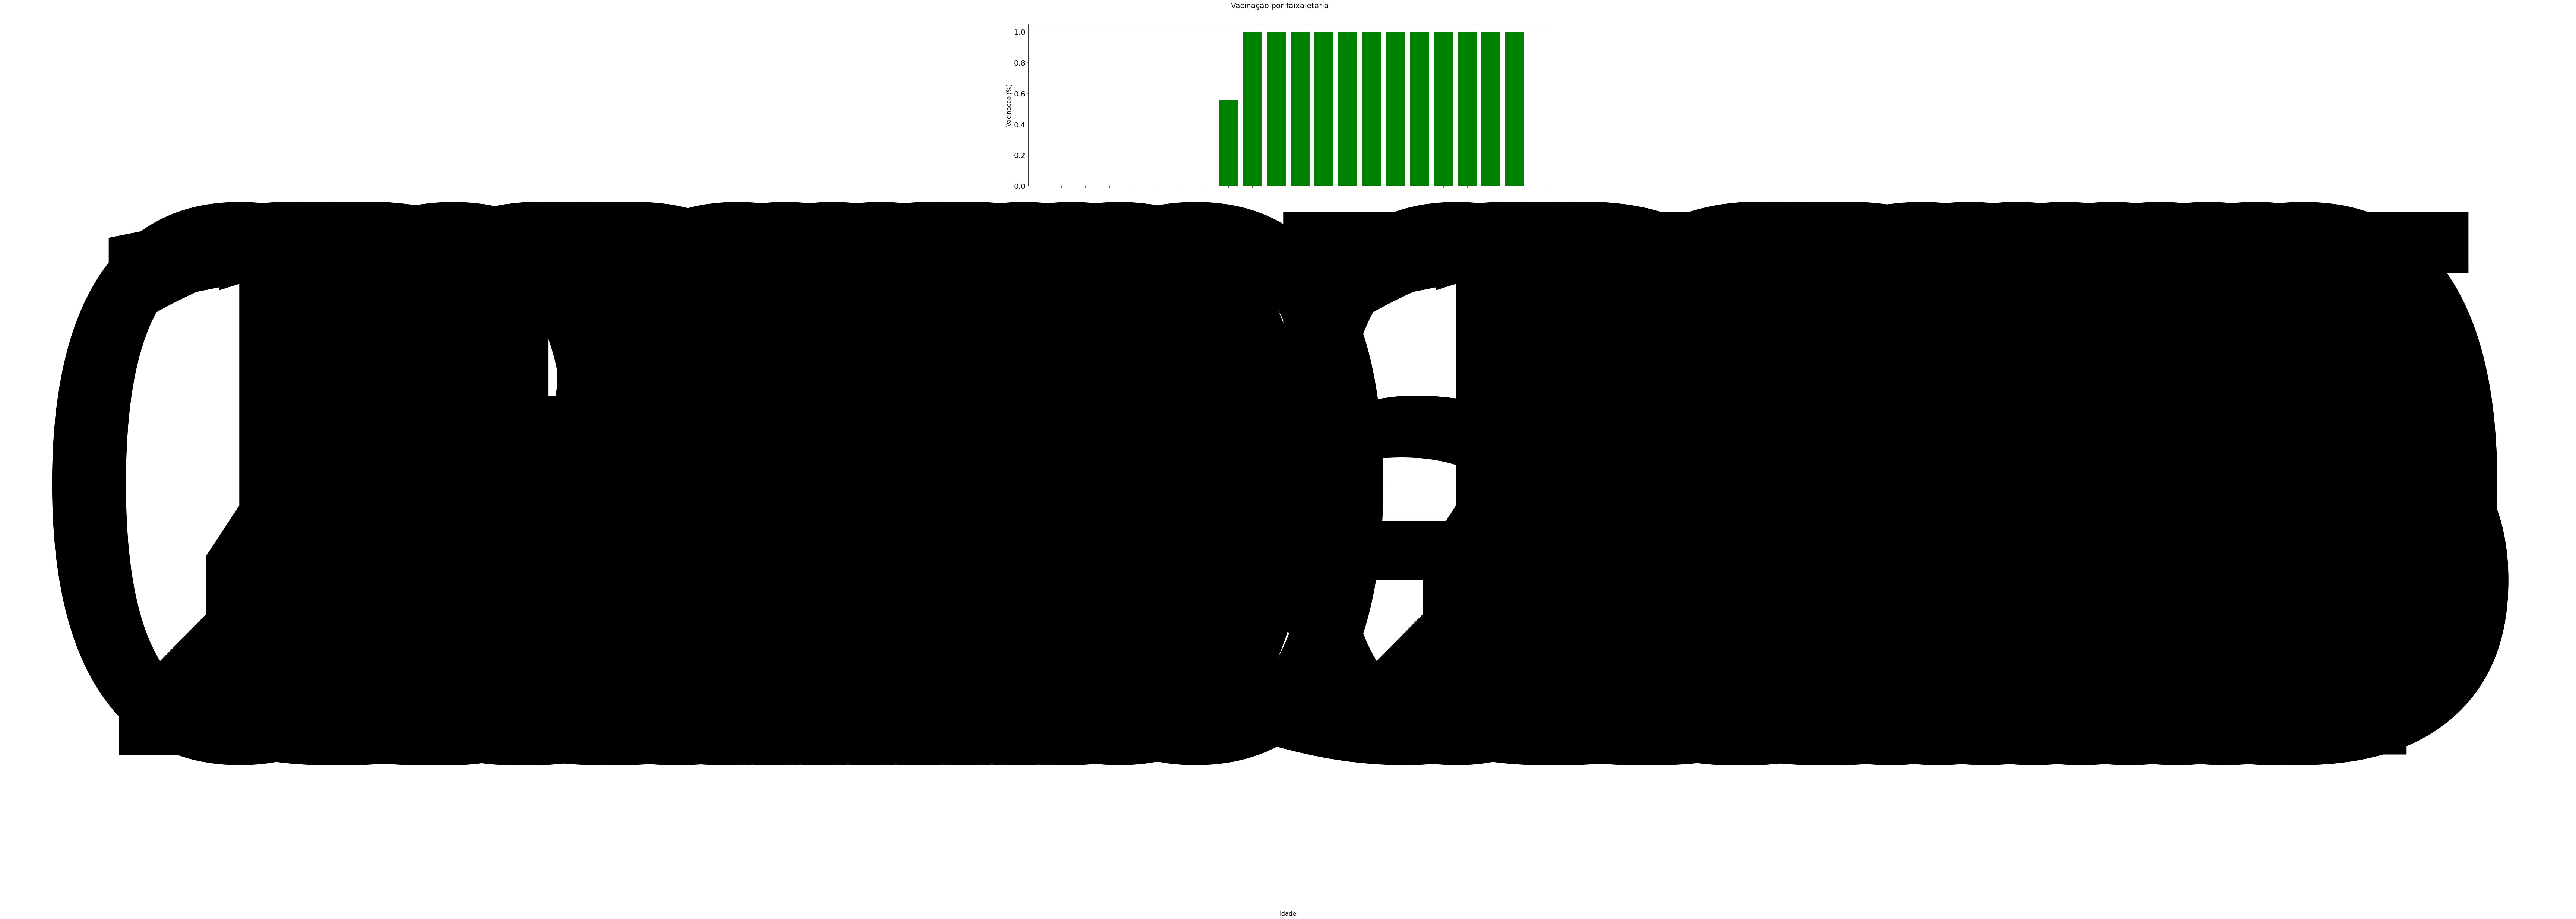

In [17]:
plt.figure(figsize=(25,8))
plt.bar(faixa_etaria, X_vacina_percentual, color = 'green')
plt.suptitle('Vacinação por faixa etaria', fontsize=20)
plt.xlabel('Idade', fontsize=16)
plt.ylabel('Vacinacao (%)', fontsize=16)
plt.show()

#### Discussao:

Conforme indicado no ultimo grafico de barras, o padrão de distribuição de vacinação segue a ordem decrescente de idade, ou seja, primeiros os mais velhos. Algo que é interessante notar é que o grupo prioritario para a vacinação não é necessaramente o mais velho, e sim o de maior risco, e analisando o grafico da "Letalidade x Faixa Etaria" o grupo de maior risco é o de faixa etária 85-89 anos. Isto pode ser comprovdo rodando o programa com uma baixa quantidade de vacina.

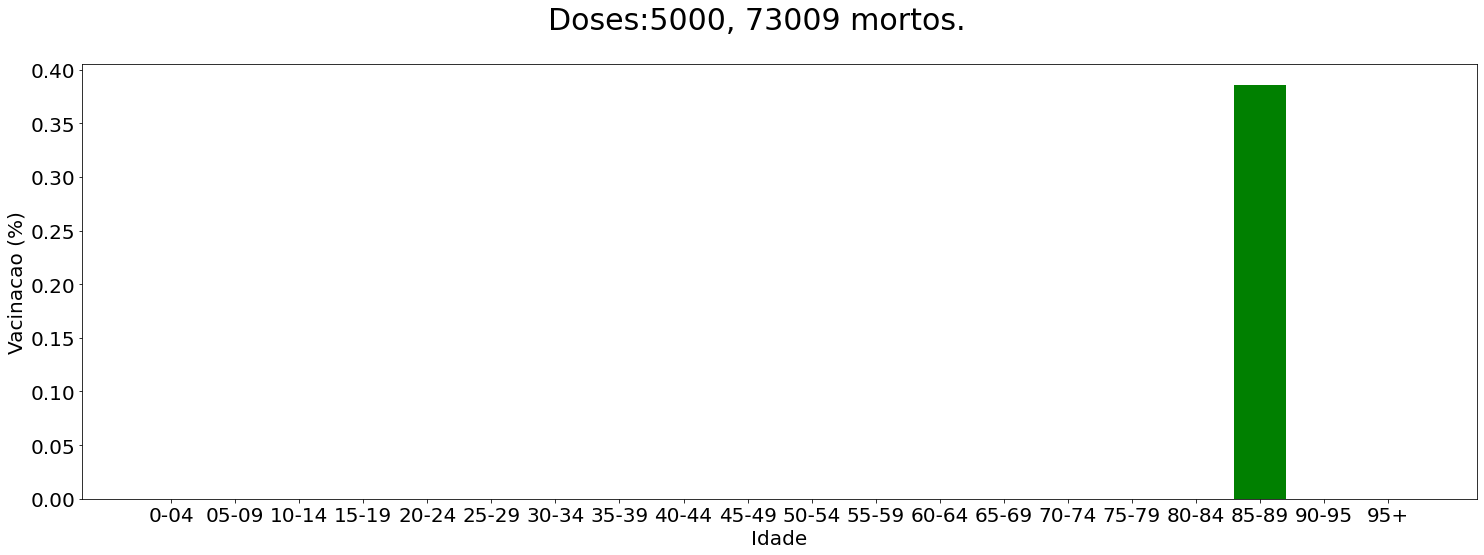

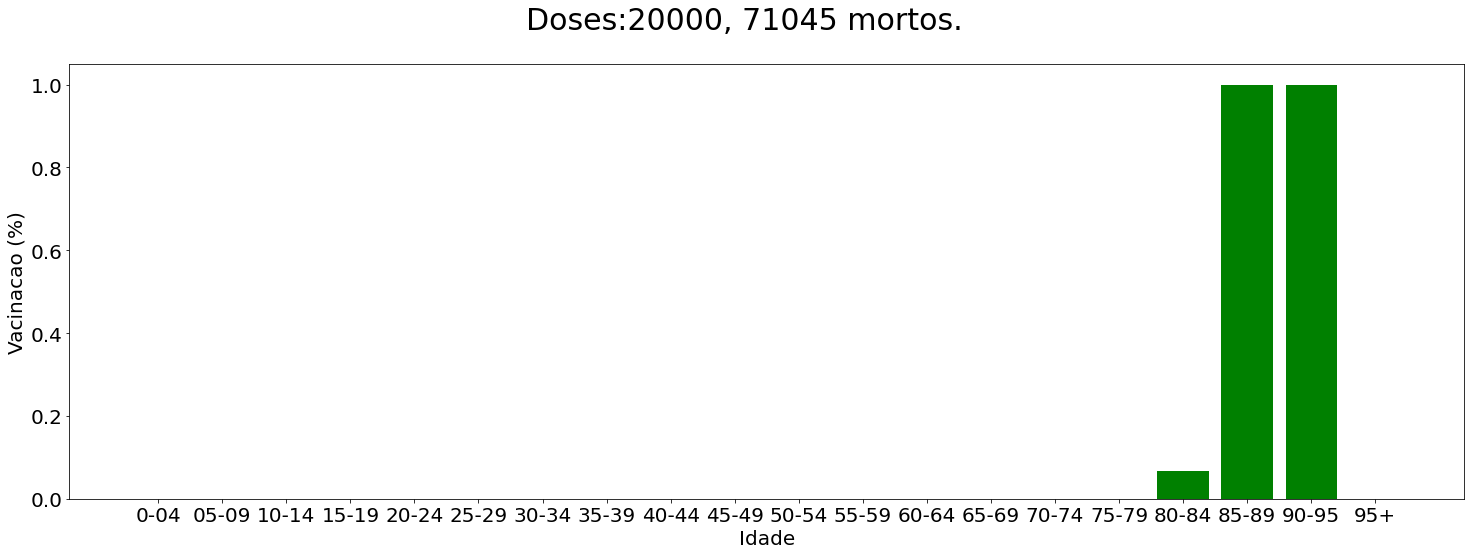

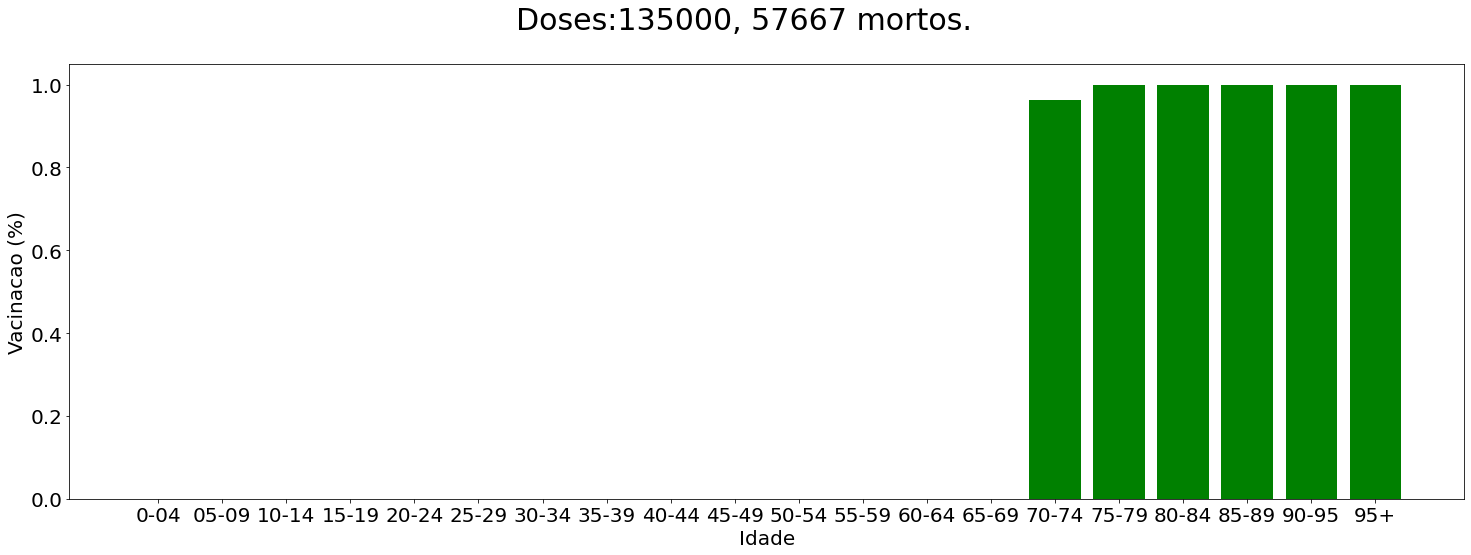

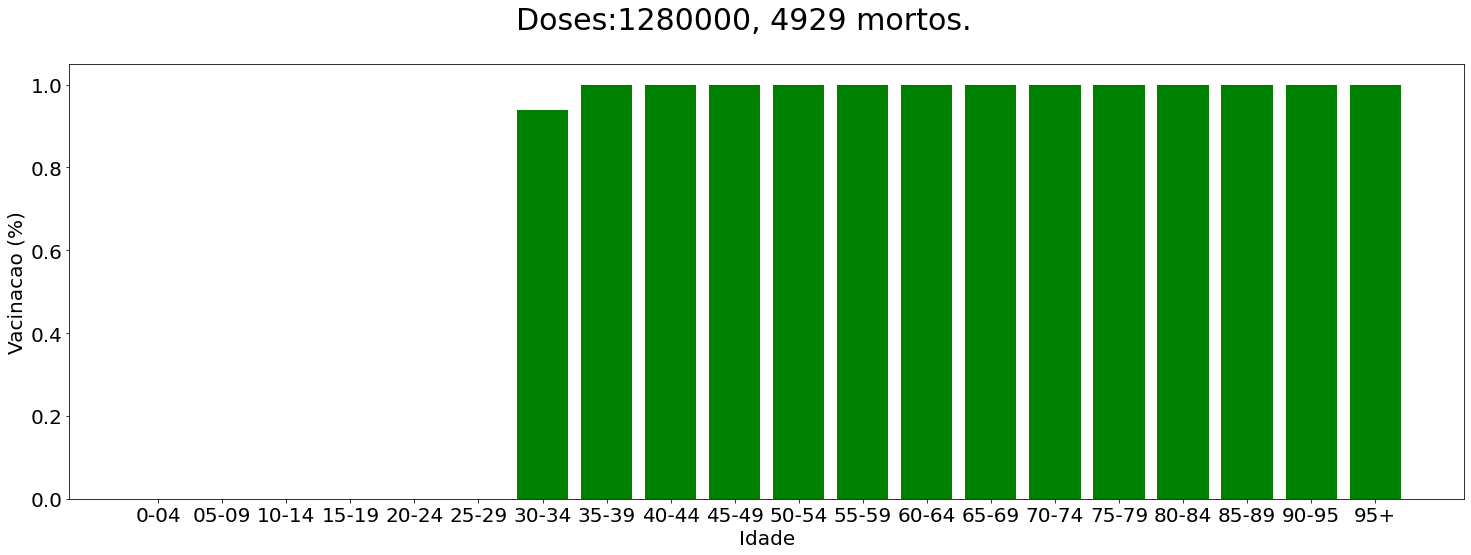

In [18]:
# Distribuição da vacinação variando a quantidade de doses:
for j in range(0,4):
    
    max_vacina = 5000*(j+1)**(j+1)

    modelo_minVac = Model(name='Grupo Prioritario')
    x_min = modelo_minVac.integer_var_list(len(populacao))

    modelo_minVac.add_constraint(sum(x_min) <= max_vacina)
    modelo_minVac.add_constraint(sum(x_min) <= sum(populacao))
    for i in range(0, len(populacao)):
        modelo_minVac.add_constraint(x_min[i] >= 0)
        modelo_minVac.add_constraint(x_min[i] <= populacao[i])

    modelo_minVac.minimize(objFunction(x_min))
    pri_solution = modelo_minVac.solve()
    min_xVac = pri_solution.get_all_values()

    min_X_vacina_percentual = []
    for i in range(0,len(min_xVac)):
        min_X_vacina_percentual.append(min_xVac[i]/populacao[i])

    plt.figure(figsize=(25,8))
    plt.bar(faixa_etaria, min_X_vacina_percentual, color = 'green')
    plt.suptitle('Doses:'+str(max_vacina)+', '+str(int(pri_solution.get_objective_value()))+' mortos.', fontsize=30)
    plt.xlabel('Idade', fontsize=20)
    plt.ylabel('Vacinacao (%)', fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.show()

Na sequencia acima ficou evidente que existe uma prioridade etária e que está não é a de maior idade e sim de maior risco de morte.

#### Melhorias no modelo:

Neste modelo foram usados dados extraidos das fontes nas referencias, porém alguns desses dados, além de serem dificieis de conseguir não necessariamente reflete as peculiaridades das incidencias dessas doenças no territorio brasileiro. Os dados referentes as comorbidades cardiacas, cancer e hipertensao são valores médios globais, comorbidades respiratórias são valores medios referentes a estas no Brasil, enquanto a taxa de incidencia da letalidade do covid-19 sem comorbidade é referente ao Reino Unido, e neste trabalho ela foi generalizada para a população de Belo Horizonte.
As taxas de letlidade por comorbidades também são médias globais e foram generalidades para a nossa população.

É interessante notar que os valores incidencia das comorbidades por idade não são valores que garantem a exclusividade destas como comorbidade única no paciente, ou seja, algumas comorbidades são relacionadas a outras, por exemplo hipertensão, problemas cardiacos e diabetes tem forte correlação. Desse modo o ideal é usar um modelo estatistico que calcule as probabilidades das comorbidades levando em consideração as correlações entre elas, assim não garantimos que o indice de letalidade por idade não seja sobredimensionado.

---
#### Referencias:
covid-19: https://www.worldometers.info/coronavirus/

Cardiovascular_disease: https://www.cureus.com/articles/36728-global-epidemiology-of-ischemic-heart-disease-results-from-the-global-burden-of-disease-study

Chronic_respiratory_disease: https://www.scielo.br/scielo.php?script=sci_arttext&pid=S1415-790X2020000100421

Diabetes: https://www.diabetesresearchclinicalpractice.com/action/showPdf?pii=S0168-8227%2819%2931230-6

hypertension: https://www.researchgate.net/publication/292678578_Hypertension_and_Aging

cancer: https://www.cancerresearchuk.org/health-professional/cancer-statistics/incidence/age#heading-Zero
